# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.metrics import AUC
%load_ext tensorboard

# Loading Dataset

In [2]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0-small/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0-small/valid')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")

There are 1001
There are 201


In [3]:
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/valid.csv'))
print(train_df.head())     # printing first five rows of the file
print(train_df.columns)
print(valid_df.head())     # printing first five rows of the file
print(valid_df.columns)

                                                Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN     

# Image Preprocessing

In [4]:
from tqdm import tqdm
from keras.preprocessing import image

#training images preprocessing
SIZE = 320

train_images = []
for i in tqdm(range(train_df.shape[0])):
    img = image.load_img(source_path +'/'+ train_df['Path'][i], target_size =(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    train_images.append(img)

train_images = np.array(train_images)
print(train_images.shape)
print(train_images.dtype)

#validation images preprocessing
size = 300
valid_images = []
for i in tqdm(range(valid_df.shape[0])):
    img = image.load_img(source_path +'/'+ valid_df['Path'][i], target_size =(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    valid_images.append(img)

valid_images = np.array(valid_images)
print(valid_images.shape)
print(valid_images.dtype)

100%|██████████| 4075/4075 [00:05<00:00, 781.93it/s]


(4075, 320, 320, 3)
float32


100%|██████████| 234/234 [00:00<00:00, 821.29it/s]


(234, 320, 320, 3)
float32


# Plot Sample Image

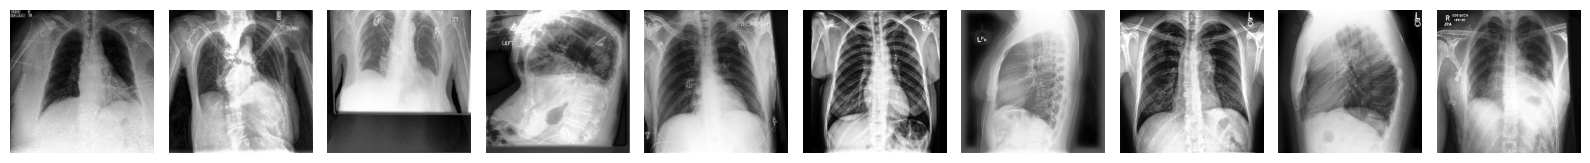

In [5]:
# Plot a sample of 10 images from the training set
import string
from tensorflow.keras.preprocessing.image import array_to_img

def plot_categories(train_images):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = train_images[k]
    #img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    #ax.set_title(f"{letters[int(train_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_images)

# Creating DataFrames

In [6]:
train_df = train_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
print(train_df.head())     # printing first five rows of the file
print(train_df.columns)

                                                Path Frontal/Lateral  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         Frontal   
1  CheXpert-v1.0-small/train/patient00002/study2/...         Frontal   
2  CheXpert-v1.0-small/train/patient00002/study1/...         Frontal   
3  CheXpert-v1.0-small/train/patient00002/study1/...         Lateral   
4  CheXpert-v1.0-small/train/patient00003/study1/...         Frontal   

   Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion  
0           NaN    NaN            NaN          NaN               NaN  
1          -1.0   -1.0           -1.0         -1.0              -1.0  
2           NaN    NaN           -1.0          NaN               NaN  
3           NaN    NaN           -1.0          NaN               NaN  
4           NaN    1.0            NaN          NaN               NaN  
Index(['Path', 'Frontal/Lateral', 'Cardiomegaly', 'Edema', 'Consolidation',
       'Atelectasis', 'Pleural Effusion'],
      dtype='object')


In [7]:
valid_df = valid_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
print(valid_df.head())     # printing first five rows of the file
print(valid_df.columns)

                                                Path Frontal/Lateral  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...         Frontal   
1  CheXpert-v1.0-small/valid/patient64542/study1/...         Frontal   
2  CheXpert-v1.0-small/valid/patient64542/study1/...         Lateral   
3  CheXpert-v1.0-small/valid/patient64543/study1/...         Frontal   
4  CheXpert-v1.0-small/valid/patient64544/study1/...         Frontal   

   Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion  
0           1.0    0.0            0.0          0.0               0.0  
1           0.0    0.0            0.0          0.0               0.0  
2           0.0    0.0            0.0          0.0               0.0  
3           0.0    1.0            0.0          0.0               0.0  
4           0.0    0.0            0.0          0.0               0.0  
Index(['Path', 'Frontal/Lateral', 'Cardiomegaly', 'Edema', 'Consolidation',
       'Atelectasis', 'Pleural Effusion'],
      dtype='object')


# Train and Valid Labels

In [8]:
train_df_UMultiClass = train_df.replace(-1,2).fillna(0)
print(len(train_df_UMultiClass))
train_labels = np.array(train_df_UMultiClass.drop(['Path', 'Frontal/Lateral'], axis=1))
print(train_labels)

4075
[[0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2.]
 [0. 0. 2. 0. 0.]
 ...
 [0. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [18]:
#Transforming Training Labels to 15 classes

trans_train_labels = np.zeros((4075, 15))
for i in range(0,4075):
    for j in range (0,5):
        index = int(j * 3 + train_labels[i,j])
        trans_train_labels[i,index] = 1
        
print(trans_train_labels[0])

# Separating the labels for 5 Pathologies

train_Pathology1_labels = trans_train_labels[:, :3].astype('float32')
train_Pathology2_labels = trans_train_labels[:,3:6].astype('float32')
train_Pathology3_labels = trans_train_labels[:,6:9].astype('float32')
train_Pathology4_labels = trans_train_labels[:,9:12].astype('float32')
train_Pathology5_labels = trans_train_labels[:,12:15].astype('float32')

print(train_Pathology1_labels[0])
print(train_Pathology2_labels[0])
print(train_Pathology3_labels[0])
print(train_Pathology4_labels[0])
print(train_Pathology5_labels[0])

[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [19]:
valid_df_UMultiClass = valid_df.replace(-1,2).fillna(0)
print(len(valid_df_UMultiClass))
valid_labels = np.array(valid_df_UMultiClass.drop(['Path', 'Frontal/Lateral'], axis=1))
print(valid_labels)

234
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]]


In [20]:
#Transforming Validation Labels to 15 classes

trans_valid_labels = np.zeros((234, 15))
for i in range(0,234):
    for j in range (0,5):
        index = int(j * 3 + valid_labels[i,j])
        trans_valid_labels[i,index] = 1
        
print(trans_valid_labels[0])

# Separating the labels for 5 Pathologies

valid_Pathology1_labels = trans_valid_labels[:, :3].astype('float32')
valid_Pathology2_labels = trans_valid_labels[:,3:6].astype('float32')
valid_Pathology3_labels = trans_valid_labels[:,6:9].astype('float32')
valid_Pathology4_labels = trans_valid_labels[:,9:12].astype('float32')
valid_Pathology5_labels = trans_valid_labels[:,12:15].astype('float32')

print(valid_Pathology1_labels[0])
print(valid_Pathology2_labels[0])
print(valid_Pathology3_labels[0])
print(valid_Pathology4_labels[0])
print(valid_Pathology5_labels[0])

[0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


# Augementation

In [21]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
])

# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [22]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, (train_Pathology1_labels, train_Pathology2_labels, train_Pathology3_labels,
                                              train_Pathology4_labels, train_Pathology5_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((valid_images, (valid_Pathology1_labels, valid_Pathology2_labels, valid_Pathology3_labels,
                                             valid_Pathology4_labels, valid_Pathology5_labels)))

In [23]:
def prepare(ds, shuffle=False, augment=False):

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)
    
  # Cache all datasets
  ds = ds.cache()

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [24]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(test_ds)

# Build the Model

In [25]:
from tensorflow.keras.applications import DenseNet121

pre_trained_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(320,320,3)
    )

for layer in pre_trained_model.layers:
    layer.trainable=False

In [26]:
#pre_trained_model.summary()

In [27]:
model = pre_trained_model.output
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(units = 128, activation = 'relu')(model)

Pathology1 = tf.keras.layers.Dense(units = 3, activation = 'softmax')(model)
Pathology2 = tf.keras.layers.Dense(units = 3, activation = 'softmax')(model)
Pathology3 = tf.keras.layers.Dense(units = 3, activation = 'softmax')(model)
Pathology4 = tf.keras.layers.Dense(units = 3, activation = 'softmax')(model)
Pathology5 = tf.keras.layers.Dense(units = 3, activation = 'softmax')(model)

model = Model(pre_trained_model.input, outputs=[Pathology1, Pathology2, Pathology3, Pathology4, Pathology5])

for layer in model.layers:
  layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']      

In [28]:
#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. _

model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999),loss='binary_crossentropy', 
              metrics=['binary_accuracy', AUC()])

# Train the Model

In [29]:
import time

start = time.time()
history = model.fit(train_ds, epochs=3, validation_data=(valid_ds), batch_size=16)

print("Total time: ", time.time() - start, "seconds")

Epoch 1/3
128/128 [==============================] - 254s 2s/step - loss: 4.5134 - dense_1_loss: 0.7555 - dense_2_loss: 1.2361 - dense_3_loss: 0.6489 - dense_4_loss: 0.7995 - dense_5_loss: 1.0734 - dense_1_binary_accuracy: 0.7353 - dense_1_auc: 0.7711 - dense_2_binary_accuracy: 0.4647 - dense_2_auc: 0.2524 - dense_3_binary_accuracy: 0.6854 - dense_3_auc: 0.6789 - dense_4_binary_accuracy: 0.5777 - dense_4_auc: 0.4999 - dense_5_binary_accuracy: 0.6498 - dense_5_auc: 0.5936 - val_loss: 4.9903 - val_dense_1_loss: 0.7801 - val_dense_2_loss: 1.6209 - val_dense_3_loss: 0.5588 - val_dense_4_loss: 0.7795 - val_dense_5_loss: 1.2510 - val_dense_1_binary_accuracy: 0.7550 - val_dense_1_auc: 0.8000 - val_dense_2_binary_accuracy: 0.4501 - val_dense_2_auc: 0.2214 - val_dense_3_binary_accuracy: 0.7678 - val_dense_3_auc: 0.8319 - val_dense_4_binary_accuracy: 0.5670 - val_dense_4_auc: 0.4743 - val_dense_5_binary_accuracy: 0.6980 - val_dense_5_auc: 0.6625
Epoch 2/3
128/128 [==============================]

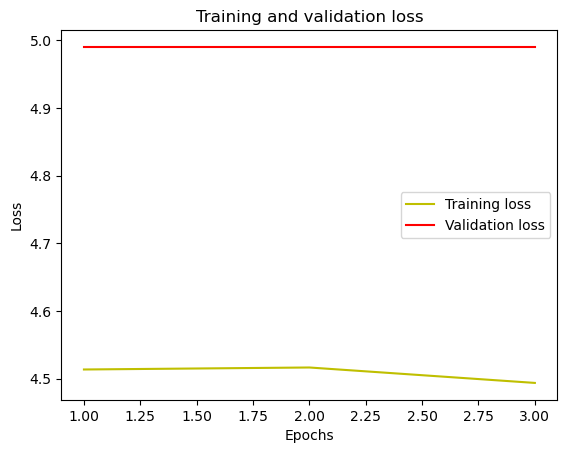

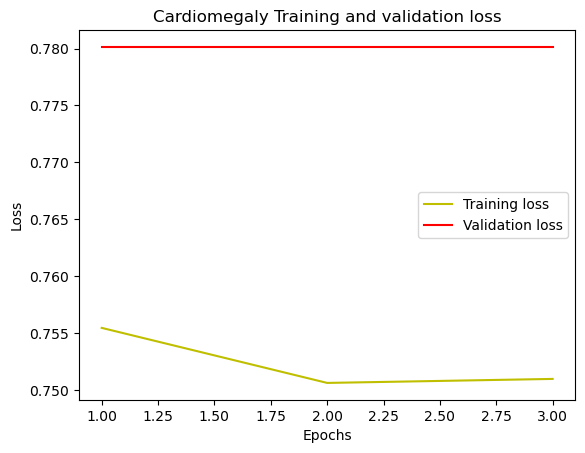

In [32]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss = history.history['dense_1_loss']
val_loss = history.history['val_dense_1_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Cardiomegaly Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model

In [33]:
ds= valid_ds
print("Test Accuracy: ", model.evaluate(ds)[1])

8/8 [==============================] - 12s 1s/step - loss: 4.9903 - dense_1_loss: 0.7801 - dense_2_loss: 1.6209 - dense_3_loss: 0.5588 - dense_4_loss: 0.7795 - dense_5_loss: 1.2510 - dense_1_binary_accuracy: 0.7550 - dense_1_auc: 0.8000 - dense_2_binary_accuracy: 0.4501 - dense_2_auc: 0.2214 - dense_3_binary_accuracy: 0.7678 - dense_3_auc: 0.8319 - dense_4_binary_accuracy: 0.5670 - dense_4_auc: 0.4743 - dense_5_binary_accuracy: 0.6980 - dense_5_auc: 0.6625
Test Accuracy:  0.7801390886306763


In [34]:
import numpy as np

# Initialize empty lists to store predictions and actual labels for each pathology
all_predictions = [[] for _ in range(5)]  # Create empty lists for each pathology
all_actual_labels = [[] for _ in range(5)]  # Create empty lists for each pathology

# Iterate over the dataset and collect predictions for individual images
for (images, labels) in valid_ds:
    predictions = model.predict(images)  # Get predictions for the current batch of images
    for i, pathology_predictions in enumerate(predictions):
        all_predictions[i].extend(pathology_predictions)
        all_actual_labels[i].extend(labels[i])  # Collect actual labels for each pathology

# Convert predictions to 1 if > 0.5, 0 otherwise for each pathology
threshold = 0.5
rounded_predictions = [(np.array(pred) > threshold).astype(int) for pred in all_predictions]
actual = [np.array(labels).astype(int) for labels in all_actual_labels]

# Print the actual labels and predictions for the first 10 images for each pathology
for i, pathology_name in enumerate(['Pathology1', 'Pathology2', 'Pathology3', 'Pathology4', 'Pathology5']):
    print(f"{pathology_name} - Actual vs. Prediction for the first 10 images:")
    for j in range(10):
        prediction_10 = rounded_predictions[i][j]
        actual_10 = actual[i][j]
        print(f"Actual Labels: {actual_10}")
        print(f"Predictions  : {prediction_10}")
        print()

1/1 [==============================] - 2s 2s/step
Pathology1 - Actual vs. Prediction for the first 10 images:
Actual Labels: [0 1 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Actual Labels: [0 1 0]
Predictions  : [1 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Actual Labels: [1 0 0]
Predictions  : [0 0 0]

Actual Labels: [1 0 0]
Predictions  : [1 0 0]

Pathology2 - Actual vs. Prediction for the first 10 images:
Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [0 1 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predictions  : [0 1 0]

Actual Labels: [1 0 0]
Predicti

# AUC and ROC curve

In [35]:
# Actual vs Predicted per Pathology

pathology = 3      # 0-Cardiomegaly, 1-Edema, 2-Consolidation, 3-Atelectasis, 4-Pleural Effusion 

pred_pathology = rounded_predictions[pathology]
actual_pathology = actual[pathology]

multi_class_pred = np.argmax(pred_pathology, axis =1)
multi_class_actual = np.argmax(actual_pathology, axis =1)

print(f"pred_pathology: {multi_class_pred}")
print(f"actual_pathology: {multi_class_actual}")

pred_pathology: [0 1 0 2 2 2 2 0 0 0 0 0 0 0 1 0 2 2 0 0 0 2 0 0 0 1 0 0 0 1 1 0 0 0 2 0 0
 0 1 0 2 0 0 0 0 1 2 1 2 2 2 0 2 0 0 0 2 0 2 2 2 0 0 0 1 0 2 2 2 0 0 0 1 0
 2 1 0 2 0 1 0 0 0 1 2 1 2 0 1 2 0 1 0 1 0 0 1 0 0 1 1 2 2 0 0 0 0 0 2 2 0
 2 2 2 1 0 1 0 0 0 0 0 0 0 2 2 0 2 0 0 2 0 0 2 0 0 0 1 2 0 0 0 1 0 2 0 0 0
 0 2 2 0 1 0 0 0 0 0 2 0 0 0 2 0 2 1 2 0 2 2 0 0 1 2 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 0 0 2 2 0 2 0 0 0 0 0 2 0 0 1 1 0 2 0 2 0 2 2 2 2 2 0 2 1 0 0 1 0 1
 1 2 0 0 0 0 2 0 0 2 2 1]
actual_pathology: [0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1
 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1
 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1]


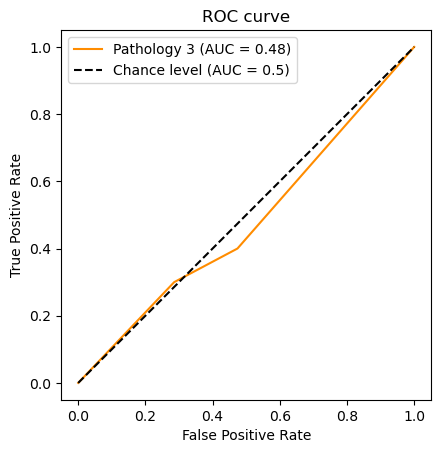

In [36]:
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(multi_class_actual, multi_class_pred)

RocCurveDisplay.from_predictions(
    multi_class_actual,
    multi_class_pred,
    name=f"Pathology {pathology}",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [37]:
# Confusion Matrix

cm=confusion_matrix(multi_class_actual, multi_class_pred)  
print(cm)

[[81 29 44]
 [48  8 24]
 [ 0  0  0]]


In [38]:
# Finding the Ideal Threshold

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  2    1.0
Name: thresholds, dtype: float64


In [39]:
# AUC value

auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.4769480519480519
